
## Autoregressive Integrated Moving Averages (ARIMA)

and 


## Seasonal Autoregressive Integrated Moving Averages (SARIMA)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.api import qqplot
%matplotlib inline

from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.tsa.arima_model import ARIMA


from sklearn.metrics import mean_squared_error,mean_squared_log_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Retail Sales Time Series Forecasting/missing_value_handled/missing_value_handled.csv')
df=df.sort_values(by='Date') 
df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,d,c,5350.0,8.0,2010.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,2013-01-01,0,0,0,0,a,1
679363,746,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec",2,2013-01-01,0,0,0,0,a,1
155193,171,a,a,2640.0,8.0,2010.0,0,0.0,0.0,0,2,2013-01-01,0,0,0,0,a,1
632403,694,a,c,460.0,11.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",2,2013-01-01,0,0,0,0,a,1
361623,396,a,c,23130.0,8.0,2010.0,0,0.0,0.0,0,2,2013-01-01,0,0,0,0,a,1


In [6]:
df.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
dtype: object

In [7]:
df= df[df['Store'] == 2]
df=df[["Date","Sales"]]
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.head()

,Sales
Date,
2013-01-01,0
2013-01-02,4422
2013-01-03,4159
2013-01-04,4484
2013-01-05,2342


In [8]:
df.describe()

,Sales
count,942.000000
mean,4122.991507
std,2363.628674
min,0.000000
25%,2806.750000
50%,4395.500000
75%,5804.500000
max,10682.000000


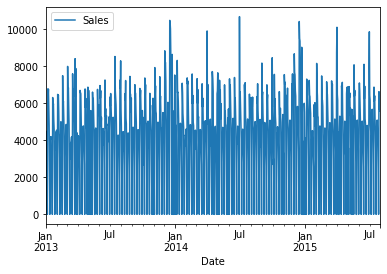

In [9]:
df.plot()

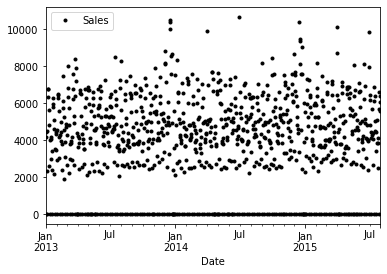

In [10]:
df.plot(style='k.')

In [11]:
df.shape

(942, 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a9d361860>]],
      dtype=object)

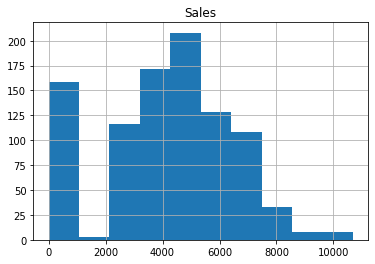

In [12]:
df.hist()

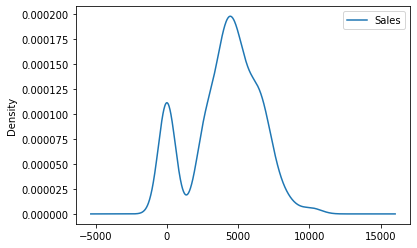

In [13]:
df.plot(kind='kde')

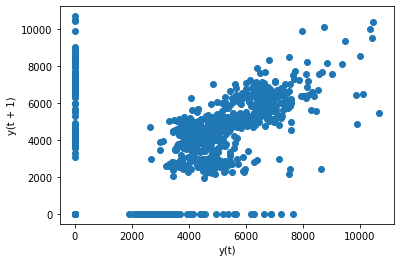

In [14]:
lag_plot(df)
plt.show()

In [15]:
# smoothing
moving_average_df=df.rolling(window=20).mean()  
moving_average_df

,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
...,...
2015-07-27,3984.15
2015-07-28,3983.90
2015-07-29,4099.90


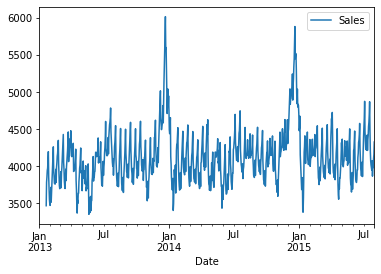

In [16]:
moving_average_df.plot()

In [17]:
sm.stats.durbin_watson(df) # correlation

array([0.39158623])

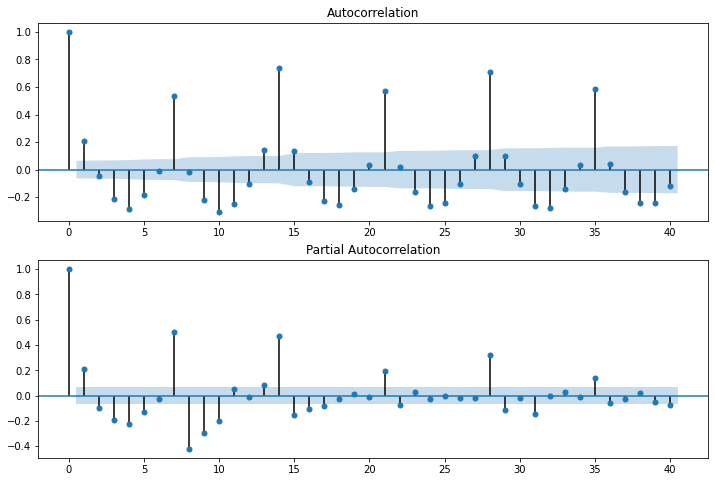

In [18]:
# acf and pacf plots
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

In [19]:
# Test for stationarity

test_result=adfuller(df['Sales'])
test_result

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(df['Sales'])

ADF Test Statistic : -6.369023763780526
p-value : 2.370294894865642e-08
#Lags Used : 21
Number of Observations Used : 920
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [20]:
#test data 2015-07-01 to 2015-07-31
training_data,test_data=df[df.index<'2015-07-01'],df[df.index>='2015-07-01']

In [21]:
print(df.shape)
print(training_data.shape)
print(test_data.shape)

(942, 1)
(911, 1)
(31, 1)


In [22]:
# ARIMA
arima= ARIMA(training_data,order=(1,1,1))
model=arima.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  910
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8347.739
Method:                       css-mle   S.D. of innovations           2323.676
Date:                Thu, 11 Feb 2021   AIC                          16703.478
Time:                        10:53:05   BIC                          16722.732
Sample:                    01-02-2013   HQIC                         16710.829
                         - 06-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3166      0.368      0.859      0.390      -0.406       1.039
ar.L1.D.Sales     0.2061      0.033      6.321      0.000       0.142       0.270
ma.L1.D.Sales    -1.0000      0.003   -355.418      0.000      -1.005      -0.994
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.8509           +0.0000j            4.8509            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [23]:
model.aic

16703.477774558305

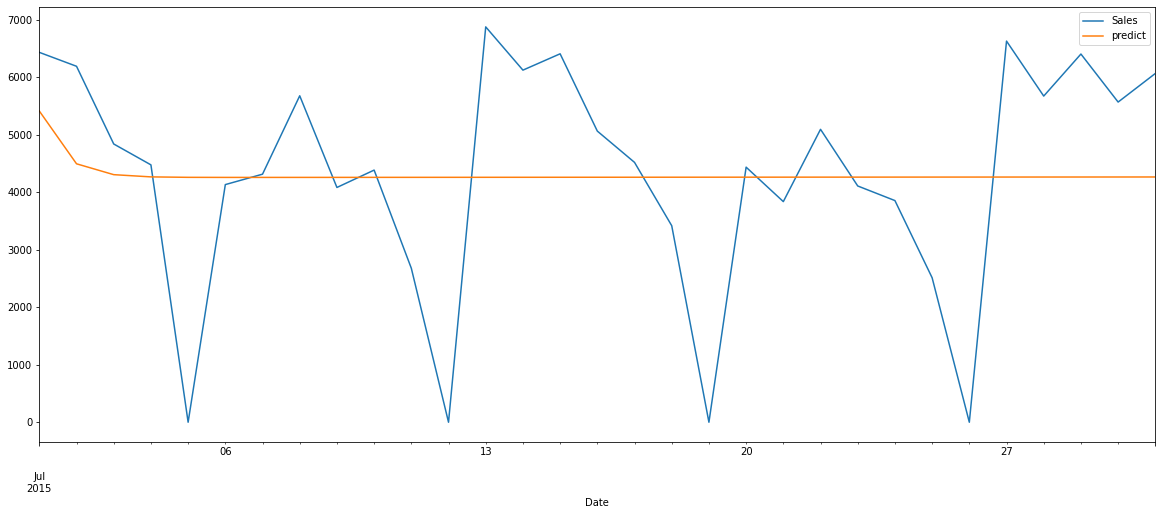

In [24]:
pred= model.forecast(steps=31)[0]
test_data['predict']=pred
test_data[['Sales','predict']].plot(figsize=(20,8))

In [25]:

# SARIMA
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2

pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  942
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8542.386
Date:                            Thu, 11 Feb 2021   AIC                          17094.771
Time:                                    10:53:23   BIC                          17118.942
Sample:                                01-01-2013   HQIC                         17103.991
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2030      0.030      6.703      0.000       0.144       0.262
ma.L1         -1.0000      0.539     -1.854      0.064      -2.057       0.057
ar.S.L12      -0.0859      0.045     -1.923      0.054      -0.174       0.002
ma.S.L12      -0.9990      0.542     -1.845      0.065      -2.060       0.062
sigma2      5.336e+06   1.01e-07   5.28e+13      0.000    5.34e+06    5.34e+06
===================================================================================
Ljung-Box (Q):                     2647.72   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.00   Prob(JB):                         0.93
Heteroskedasticity (H):               1.15   Skew:                            -0.02
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.38e+29. Standard errors may be unstable.
"""

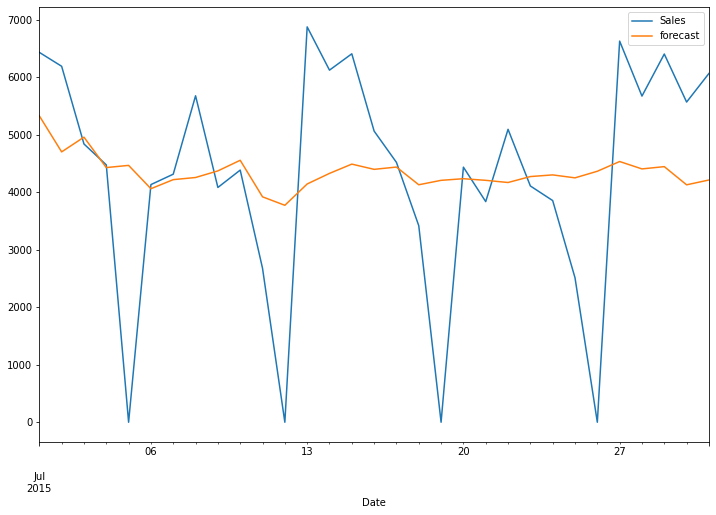

In [27]:
test_data['forecast']=results.predict(start=-31,dynamic=True)
test_data[['Sales','forecast']].plot(figsize=(12,8))

In [28]:
test_data

,Sales,predict,forecast
Date,,,
2015-07-01,6431,5411.011073,5327.212171
2015-07-02,6189,4493.491803,4700.713047
2015-07-03,4838,4304.597961,4956.640818
2015-07-04,4475,4265.909118,4427.903889
2015-07-05,0,4258.184803,4465.848969
2015-07-06,4132,4256.843778,4060.332090
2015-07-07,4313,4256.818657,4217.918667
2015-07-08,5676,4257.064808,4255.279365
2015-07-09,4082,4257.366882,4370.121915


In [29]:

print("RMSE =",np.sqrt(mean_squared_error(test_data['Sales'], test_data['predict'])))

RMSE = 1959.1522831894613
